In [2]:
import pickle as pk

In [32]:
import numpy
import pandas as pd

In [4]:
from numpy import mean
from numpy import std

In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [10]:
data = pd.read_csv("weblog.csv")
data=data.dropna()
data.IP=data.IP.str.replace('.', '')
data.head(4)

C:\Users\DHRUVS~1\AppData\Local\Temp/ipykernel_26228/3328530410.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.IP=data.IP.str.replace('.', '')


,IP,Time,URL,Staus
0,1012821,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200
1,1012821,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302
2,1012821,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200
3,1013121,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200


In [11]:
#data.IP=data.IP.str.replace('.', '')
data=data.dropna()
data.IP = data.IP.astype('int32')
data=data.drop('URL',axis='columns')
data=data.drop('Time',axis='columns')
#df['A1'].replace(regex=True, inplace=True, to_replace=r'[^0-9.\-]', value=r'']
data.head(3)

,IP,Staus
0,1012821,200
1,1012821,302
2,1012821,200


In [36]:
#loading data for Feature Selection
data['Prep'] = numpy.ones(15789)
dataAr = data.values
X, y = dataAr[:, :-1], dataAr[:, -1]
# minimally prepare dataset
X = X.astype('float')
y = LabelEncoder().fit_transform(y.astype('str'))

In [37]:
#Feature Extraction
# minimally prepare dataset
X = X.astype('float')
y = LabelEncoder().fit_transform(y.astype('str'))
print(X,y)
# transforms for the feature union
transforms = list()
transforms.append(('mms', MinMaxScaler()))
transforms.append(('ss', StandardScaler()))
transforms.append(('rs', RobustScaler()))
transforms.append(('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal')))
transforms.append(('kbd', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')))
transforms.append(('pca', PCA(n_components=7)))
transforms.append(('svd', TruncatedSVD(n_components=7)))

[[1.012821e+06 2.000000e+02]
 [1.012821e+06 3.020000e+02]
 [1.012821e+06 2.000000e+02]
 ...
 [1.013021e+06 2.000000e+02]
 [1.013021e+06 2.000000e+02]
 [1.013021e+06 2.000000e+02]] [0 0 0 ... 0 0 0]


In [38]:
def ogfs(y_true,y_pred):
    hamming_loss(y_true, y_pred)
    accuracy_score(y_true, y_pred)
    #Used for Binary class
    # print(precision_score(y_true, y_pred))
    # print(f1_score(y_true, y_pred))
    #Used for multiclass
    zero_one_loss(y_true, y_pred)
    # The best possible score is 1.0, lower values are worse.
    explained_variance_score(y_true, y_pred)
    mean_absolute_error(y_true, y_pred)
    mean_squared_log_error(y_true, y_pred)
    median_absolute_error(y_true, y_pred)
    r2_score(y_true, y_pred)
    confusion_matrix(y_true, y_pred)

In [39]:
# create the feature union
fu = FeatureUnion(transforms)

In [40]:
# define the feature selection
rfe = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=15)

In [41]:
# define the model
model = LogisticRegression(solver='liblinear')
print("Transformation Set Useing Selected Data for for OGFS:\n",transforms)

Transformation Set Useing Selected Data for for OGFS:
 [('mms', MinMaxScaler()), ('ss', StandardScaler()), ('rs', RobustScaler()), ('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('kbd', KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')), ('pca', PCA(n_components=7)), ('svd', TruncatedSVD(n_components=7))]


In [42]:
# define the pipeline
steps = list()
steps.append(('fu', fu))
y_pred = [1, 2, 3, 4]
steps.append(('rfe', rfe))
y_true = [5, 6, 5,8]
steps.append(('m', model))
pipeline = Pipeline(steps=steps)

In [43]:
print("TransformsSteps",steps,"\n\n",pipeline)

TransformsSteps [('fu', FeatureUnion(transformer_list=[('mms', MinMaxScaler()),
                               ('ss', StandardScaler()), ('rs', RobustScaler()),
                               ('qt',
                                QuantileTransformer(n_quantiles=100,
                                                    output_distribution='normal')),
                               ('kbd',
                                KBinsDiscretizer(encode='ordinal', n_bins=10,
                                                 strategy='uniform')),
                               ('pca', PCA(n_components=7)),
                               ('svd', TruncatedSVD(n_components=7))])), ('rfe', RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=15)), ('m', LogisticRegression(solver='liblinear'))] 

 Pipeline(steps=[('fu',
                 FeatureUnion(transformer_list=[('mms', MinMaxScaler()),
                                                ('ss', StandardScaler()),
                 

In [44]:
# define the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [45]:
print(cv)

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)


In [46]:
# evaluate model
ogfs(y_true,y_pred)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anacond

In [47]:
# report performance
print('Prediction Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Prediction Accuracy: nan (nan)


In [48]:
#Mapping - Slicing Data
slice1 = data.iloc[0:399,:]
slice2 = data.iloc[400:800,:]
slice3 = data.iloc[801:1200,:]
slice4 = data.iloc[1201:,:]

In [51]:
def mapper(data):
    
    mapped = []
    
    for index,row in data.iterrows():
        
        mapped.append((row['IP'],row['Prep']))
        
    return mapped


In [52]:
map1 = mapper(slice1)
map2 = mapper(slice2)
map3 = mapper(slice3)
map4 = mapper(slice4)

In [53]:
shuffled = {
    3.0: [],
    4.0: [],
    5.0: [],
    6.0: [],
    7.0: [],
    8.0: [],
    
}

In [55]:
map1

[(1012821.0, 1.0),
 (1012821.0, 1.0),
 (1012821.0, 1.0),
 (1013121.0, 1.0),
 (1013021.0, 1.0),
 (1013021.0, 1.0),
 (1012821.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013021.0, 1.0),
 (1013021.0, 1.0),
 (1013021.0, 1.0),
 (1013021.0, 1.0),
 (1012921.0, 1.0),
 (1013101.0, 1.0),
 (1013101.0, 1.0),
 (1013021.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1012821.0, 1.0),
 (1013101.0, 1.0),
 (1012821.0, 1.0),
 (1013101.0, 1.0),
 (1012921.0, 1.0),
 (1013101.0, 1.0),
 (1012821.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013021.0, 1.0),
 (1012921.0, 1.0),
 (1012821.0, 1.0),
 (1012821.0, 1.0),
 (1012821.0, 1.0),
 (1012821.0, 1.0),
 (1013121.0, 1.0),
 (1012921.0, 1.0),
 (1012921.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0, 1.0),
 (1012821.0, 1.0),
 (1013121.0, 1.0),
 (1013121.0,

In [64]:
for i in [map1,map2,map3,map4]:
    for j in i:
        shuffled[j[0]].append(j[1])
    
print(shuffled)

TypeError: list indices must be integers or slices, not numpy.float64

In [23]:
file= open('shuffled.pkl','ab')
pk.dump(shuffled,file)
file.close()

print("Data has been mapped. Now, for reduce the contents in shuffled.pkl file.")

Data has been mapped. Now, for reduce the contents in shuffled.pkl file.


In [24]:
#Reduce
file= open('shuffled.pkl','rb')
shuffled = pk.load(file)

In [25]:
def reduce(shuffled_dict):
    reduced = {}
    
    for i in shuffled_dict: 
        
        reduced[i] = sum(shuffled_dict[i])/len(shuffled_dict[i])
    
    return reduced

In [26]:
final = reduce(shuffled)
print("Reduce Process Compleated")

Reduce Process Compleated


In [27]:
print("Average Quality Prediction Based on the Previous Product Quality of Data(through MapReduce): ")
pkl=[]
for i in final:
    print(i,':',final[i])
    pkl.append(final[i])

Average Quality Prediction Based on the Previous Product Quality of Data(through MapReduce): 
3.0 : 0.8845000000000001
4.0 : 0.6939622641509429
5.0 : 0.5767157584683352
6.0 : 0.4973704866562018
7.0 : 0.4039195979899498
8.0 : 0.4233333333333334


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


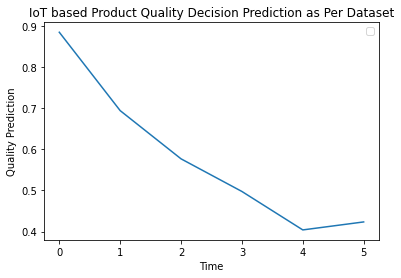

In [28]:
from matplotlib import pyplot as plt

#trainPredic = [0.8845000000000001,0.6939622641509429,0.5767157584683352,0.4973704866562018,0.4039195979899498,0.4233333333333334]
trainPredic=pkl
plt.plot(trainPredic)

plt.ylabel("Quality Prediction")
plt.xlabel("Time")

plt.title('IoT based Product Quality Decision Prediction as Per Dataset')

plt.legend()
# Display a figure.
plt.show()